## IT ticket lead time

Objective of this model is to predict the lead time of IT ticket

### This kernel is only for self referral purpose esp. for using Baeysian optimization using hyperopt

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)
plt.style.use('ggplot')

In [2]:
data = pd.read_csv('data_gdsc2_public.csv', delimiter = ';', parse_dates=['timestamp'])

In [3]:
df = data.copy()
print(df.shape)
df.head(2)

(71957, 11)


,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
0,2015-01-02 14:39:14,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,NaN,NaN,Analyze,NaN,ER_00043
1,2015-01-02 15:04:20,WI_000002,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,NaN,Analyze,NaN,ER_00225


In [5]:
df.describe()

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
count,71957,71957,71957,71957,71957,71957,49765,60393,61435,60393,61435
unique,71487,11564,3,5,11,19,315,8,8,273,275
top,2018-02-26 10:12:33,WI_006500,WT_00001,WP_00003,BD_00002,PL_00002,CO_00113,Analyze,Analyze,ER_00239,ER_00239
freq,10,34,27794,35667,15761,15761,4173,11936,12519,2995,3001
first,2015-01-02 14:39:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2018-03-30 19:07:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.dtypes

timestamp        datetime64[ns]
work_item                object
work_type                object
work_priority            object
domain                   object
platform                 object
components               object
from_phase               object
to_phase                 object
from_resource            object
to_resource              object
dtype: object

In [5]:
df.from_phase.fillna('Start', inplace=True)  
df.to_phase.fillna('End', inplace=True)

In [7]:
df.query("from_phase=='Analyze' and to_phase=='Analyze'").shape

(172, 11)

In [ ]:
# check why some tickets are not closed..
## add column if the time went in ticket lifecycle was between holidays..

In [10]:
print("col\t nunique \t unique_values")
for col in df.columns:
    print(col,'\t ', df[col].nunique(), '\t' ,df[col].unique(), '\n')

col	 nunique 	 unique_values
timestamp 	  71487 	 ['2015-01-02T14:39:14.000000000' '2015-01-02T15:04:20.000000000'
 '2015-01-02T15:28:22.000000000' ... '2018-03-30T17:30:22.000000000'
 '2018-03-30T17:37:35.000000000' '2018-03-30T19:07:03.000000000'] 

work_item 	  11564 	 ['WI_000001' 'WI_000002' 'WI_000003' ... 'WI_011562' 'WI_011563'
 'WI_011564'] 

work_type 	  3 	 ['WT_00001' 'WT_00002' 'WT_00003'] 

work_priority 	  5 	 ['WP_00003' 'WP_00004' 'WP_00002' 'WP_00001' 'WP_00005'] 

domain 	  11 	 ['BD_00001' 'BD_00002' 'BD_00003' 'BD_00004' 'BD_00005' 'BD_00006'
 'BD_00007' 'BD_00008' 'BD_00009' 'BD_00010' 'BD_00011'] 

platform 	  19 	 ['PL_00001' 'PL_00002' 'PL_00003' 'PL_00004' 'PL_00005' 'PL_00006'
 'PL_00007' 'PL_00008' 'PL_00009' 'PL_00010' 'PL_00011' 'PL_00012'
 'PL_00013' 'PL_00014' 'PL_00015' 'PL_00016' 'PL_00017' 'PL_00018'
 'PL_00019'] 

components 	  315 	 [nan 'CO_00037/CO_00071' 'CO_00113' 'CO_00141' 'CO_00132' 'CO_00084'
 'CO_00068' 'CO_00056' 'CO_00035' 'CO_00139/CO_00

In [ ]:
#number of components
#work priority as ordered integer
#How many resources ticket has flipped between
#TfiDF vectorizer for employee

In [9]:
relevant_columns = ['work_item', 'timestamp']
start_times = df[df.from_phase == 'Start'][relevant_columns]
end_times = df[df.to_phase == 'End'][relevant_columns]
print(start_times.shape, end_times.shape, start_times.shape[0] - end_times.shape[0])

times = pd.merge(start_times, end_times, on='work_item', how='left')
times.loc[times.timestamp_y.isna(),].shape
times.rename(columns={'timestamp_x': 'start', 'timestamp_y': 'end'}, inplace=True)
times['duration'] = times['end'] - times['start']
times['duration_in_days'] = times['duration'].apply(lambda x: round(x.total_seconds() / (24*3600), 2))
times.head()
# times.loc[times.timestamp_y.isna(),].head()

(11564, 2) (10522, 2) 1042


,work_item,start,end,duration,duration_in_days
0,WI_000001,2015-01-02 14:39:14,2015-01-27 11:36:51,24 days 20:57:37,24.87
1,WI_000002,2015-01-02 15:04:20,2015-01-14 09:46:37,11 days 18:42:17,11.78
2,WI_000003,2015-01-02 15:28:22,2015-02-26 11:50:37,54 days 20:22:15,54.85
3,WI_000004,2015-01-02 15:33:54,2015-01-28 09:11:05,25 days 17:37:11,25.73
4,WI_000005,2015-01-02 16:32:11,2015-02-04 12:57:49,32 days 20:25:38,32.85


In [10]:
open_times = times[pd.isnull(times.duration_in_days)]
closed_times = times[~pd.isnull(times.duration_in_days)]
closed_tickets = set(closed_times.work_item)
open_tickets = set(open_times.work_item)

In [11]:
def num_unique(x):
    funcs = {
        col:x[col].nunique() for col in df.columns
    }
    
    return pd.Series(funcs)

df_num_uniques = df.groupby('work_item').apply(num_unique).drop('work_item', axis =1).reset_index()
# df_num_uniques.head()

df_num_uniques = df_num_uniques.merge(times.drop('duration', axis = 1), on = 'work_item', how = 'left')

df_num_uniques2 = df_num_uniques.rename(columns = {'timestamp':'num_phase_changes_before_end','from_phase':'num_unique_phases_before_end',
                                                  'to_resource':'num_unique_employees'})

df_num_uniques2['num_phase_changes_before_end'] = np.where(df_num_uniques2.work_item.isin(closed_tickets), df_num_uniques2.num_phase_changes_before_end -2,df_num_uniques2.num_phase_changes_before_end -1) 
df_num_uniques2['num_unique_phases_before_end'] = np.where(df_num_uniques2.work_item.isin(closed_tickets), df_num_uniques2.num_unique_phases_before_end -1,df_num_uniques2.num_phase_changes_before_end) 

df_num_uniques2.head(2)
#### decrease the above numbers by one for closed tickets. num_phase_changes by
# 2 for closed-by 1 for open, num_unique_phases by 1 for closed - by 0 for open

,work_item,num_phase_changes_before_end,work_type,work_priority,domain,platform,components,num_unique_phases_before_end,to_phase,from_resource,num_unique_employees,start,end,duration_in_days
0,WI_000001,10,1,1,1,1,0,7,8,3,3,2015-01-02 14:39:14,2015-01-27 11:36:51,24.87
1,WI_000002,2,1,1,1,1,1,3,4,1,1,2015-01-02 15:04:20,2015-01-14 09:46:37,11.78


In [13]:
print("Number of work items with more than one work type in their lifecycle")
print(sum(df_num_uniques2.work_priority != 1))

Number of work items with more than one work type in their lifecycle
0


In [19]:
df_num_uniques2.shape

(11564, 11)

In [20]:
for col in df_num_uniques.columns:
    print(col, sum(df_num_uniques[col] ==1))
    
#     components 3721

work_item 0
timestamp 516
work_type 11564
work_priority 11564
domain 11564
platform 11564
components 7843
from_phase 516
to_phase 535
from_resource 2506
to_resource 2948


In [ ]:
#from above analysis wil keep num unique components and from_resource and to_resource as well as a variable.

# target encoding for thr from_resource and to_resource --tbd


In [14]:
#Adding time difference between start and last stage of ticket...it'll cause target leakage
#shoudl also try adding average time between stages..

df_time_diff = df.groupby('work_item').apply(lambda x: max(x['timestamp']) - min(x['timestamp']))\
    .reset_index().rename(columns={0:'time_diff'})
df_time_diff['time_diff_in_days'] = df_time_diff['time_diff'].apply(lambda x: round(x.total_seconds() / (24*3600), 2))
df_time_diff.head(2)

,work_item,time_diff,time_diff_in_days
0,WI_000001,24 days 20:57:37,24.87
1,WI_000002,11 days 18:42:17,11.78


In [14]:
#create target encoding

def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [485]:
print(df2.work_priority.value_counts())
print(df2.groupby('work_priority')['duration_in_days'].mean())
df2[df2.duration_in_days.notna()].groupby('work_item').first().groupby('work_type')['duration_in_days'].mean()

WP_00003    35667
WP_00002    15304
WP_00001     7768
WP_00004     6767
WP_00005     6451
Name: work_priority, dtype: int64
work_priority
WP_00001    29.363829
WP_00002    47.419538
WP_00003    67.300103
WP_00004    81.843750
WP_00005    72.830110
Name: duration_in_days, dtype: float64


78.99

In [16]:
def get_last_phase(x):
    last_phase = x.groupby('work_item', as_index = False).last()
    last_phase['last_phase'] = np.where(last_phase.duration_in_days.notna(), last_phase.from_phase, last_phase.to_phase)
    last_phase = last_phase[['work_item', 'last_phase']]
    return last_phase

In [19]:
def rec_time(df: pd.DataFrame) -> pd.DataFrame:
    df['recentTimes'] = df['timestamp'].apply(lambda x: round(-x.total_seconds() / (24*3600), 2))
    data_recent_duration=df[['recentTimes']]
    return data_recent_duration 

data_top2=df.groupby('work_item').apply(lambda x: x.sort_values(by=['timestamp'], ascending=False).head(2)) 
data_rec_time=data_top2.groupby('work_item')[['timestamp']].diff() 

data_recent_time=data_rec_time[data_rec_time.timestamp.notna()] 

data_recent_duration=rec_time(data_recent_time).reset_index().drop('level_1', axis = 1) 
# data_recent_duration = data_recent_duration

data_recent_duration.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 'work_item' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  import sys
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,work_item,recentTimes
0,WI_000001,7.02
1,WI_000002,0.00
2,WI_000003,0.00
3,WI_000004,11.89
4,WI_000005,6.10


In [ ]:
def work_pri(x):
    w_p=[]
    data_x=data[data.timestamp<x]
    data_x_most_recent=data_x.groupby('work_item')[['timestamp']].max()
    data_x_most_recent['id']=data_x_most_recent.index
    data_temp=pd.merge(data, data_x_most_recent, left_on=['work_item', 'timestamp'], right_on=['id', 'timestamp'], how='inner')
    pri_count=data_temp[data_temp.to_phase!='End'].work_priority.value_counts()
    pre_count_dict=pri_count.to_dict()
    WP_00001=pre_count_dict.get('WP_00001',0)
    WP_00002=pre_count_dict.get('WP_00002',0)
    WP_00003=pre_count_dict.get('WP_00003',0)
    WP_00004=pre_count_dict.get('WP_00004',0)
    WP_00005=pre_count_dict.get('WP_00005',0)
    w_p.append(WP_00001)
    w_p.append(WP_00002)
    w_p.append(WP_00003)
    w_p.append(WP_00004)
    w_p.append(WP_00005)
    return w_p

pri_list=[]
for row in data_s.timestamp:
    pri_list.append(work_pri(row))

pri_list=pd.DataFrame(pri_list)
pri_list.columns=('WP_00001', 'WP_00002', 'WP_00003', 'WP_00004', 'WP_00005')

In [40]:
df.groupby('work_item', as_index = False).first().groupby('work_priority').resample('D', on = 'timestamp')\
.count()[['work_priority']].rename(columns= {'work_priority':'count'}).reset_index()

,work_priority,timestamp,count
0,WP_00001,2015-01-06,2
1,WP_00001,2015-01-07,1
2,WP_00001,2015-01-08,1
3,WP_00001,2015-01-09,1
4,WP_00001,2015-01-10,0
5,WP_00001,2015-01-11,0
6,WP_00001,2015-01-12,2
7,WP_00001,2015-01-13,0
8,WP_00001,2015-01-14,0
9,WP_00001,2015-01-15,0


In [365]:
pri_list = pd.read_csv('data_s2.csv',usecols=['WP_00001','WP_00002','WP_00003','WP_00004','WP_00005'])
pri_list.head()
phase_list = pd.read_csv('df_phase.csv', index_col = [0]).drop('Clarify', axis = 1)\
    .rename(columns = {col:'phase_'+col for col in phase_list.columns})
phase_list.head()

,phase_Design,phase_Build,phase_Test,phase_Package,phase_Accept,phase_Deploy,phase_End,phase_work_item
0,1,1,1,1,1,1,0,WI_000001
1,1,1,1,0,0,0,0,WI_000002
2,1,1,1,1,0,0,0,WI_000003
3,1,1,1,1,1,1,0,WI_000004
4,1,1,1,0,1,1,0,WI_000005


In [44]:
def sort_x(x):
    if isinstance(x, list):
        sorted(x)
        return x
    
df_component = df.components.str.split('/').apply(sort_x).apply(pd.Series)\
.rename(columns = {0:'Component_1', 1:'Component_2', 2:'Component_3', 3:'Component_4', 4:'Component_5'})

df_component.head()

,Component_1,Component_2,Component_3,Component_4,Component_5
0,NaN,NaN,NaN,NaN,NaN
1,CO_00037,CO_00071,NaN,NaN,NaN
2,CO_00037,CO_00071,NaN,NaN,NaN
3,CO_00037,CO_00071,NaN,NaN,NaN
4,CO_00113,NaN,NaN,NaN,NaN


In [42]:
def length(x):
    if isinstance(x, list):
        return len(x)
   
#work priority as ordered integer

work_priority_list = ['WP_00003' ,'WP_00004' ,'WP_00002' ,'WP_00001', 'WP_00005']
work_priority_list.sort(reverse = True)
work_priority_map = {x:i+1 for i,x in enumerate(work_priority_list)}
work_priority_map    

{'WP_00005': 1, 'WP_00004': 2, 'WP_00003': 3, 'WP_00002': 4, 'WP_00001': 5}

In [573]:
df2 = pd.merge(df, times[['work_item', 'duration_in_days']], on = 'work_item', how = 'left')
df2.head(2)
mask_closed = df2.duration_in_days.notna()
mask_open = df2.duration_in_days.isna()

m = 2500
df2['work_type_encoding'] = round(calc_smooth_mean(df2, 'work_type', 'duration_in_days', 1000),2) #m = 0
# df2['domain_encoding'] = round(calc_smooth_mean(df2, 'domain', 'duration_in_days', m),2)
# df2['platform_encoding'] = round(calc_smooth_mean(df2, 'platform', 'duration_in_days', m),2)
# df2['work_priority_encoding'] = round(calc_smooth_mean(df2, 'work_priority', 'duration_in_days', 1000),2)

df2['num_components'] = df.components.str.split('/').apply(length)

df2.components.fillna('not_assigned', inplace = True)
df2['components_encoding'] =  round(calc_smooth_mean(df2, 'components', 'duration_in_days', 5000),2)
df2['component_assigned'] = np.where(df2.components == 'not_assigned', 0, 1)

# df2 = pd.concat([df2, df_component], axis = 1)

# df2['component_1_encoding'] =  round(calc_smooth_mean(df2, 'Component_1', 'duration_in_days', 2000),2)
# df2['component_2_encoding'] =  round(calc_smooth_mean(df2, 'Component_2', 'duration_in_days', 2000),2)
# df2['component_3_encoding'] =  round(calc_smooth_mean(df2, 'Component_3', 'duration_in_days', 2000),2)
# df2['component_4_encoding'] =  round(calc_smooth_mean(df2, 'Component_4', 'duration_in_days', 2000),2)
# df2['component_5_encoding'] =  round(calc_smooth_mean(df2, 'Component_5', 'duration_in_days', 2000),2)

# df2['total_component_encoding'] =  df2['component_1_encoding'].fillna(0) + df2['component_2_encoding'].fillna(0) +\
#                                     df2['component_3_encoding'].fillna(0) + df2['component_4_encoding'].fillna(0) +\
#                                     df2['component_5_encoding'].fillna(0)

## Componect encoding not happening properly.. fix it.. e.g COmponect_2 CO_00144

df2 = df2.merge(df_num_uniques2[['work_item','num_phase_changes_before_end','num_unique_employees']],
          on = 'work_item', how = 'left')

#, 'num_unique_phases_before_end' - remove
# num_phase_changes_before_end --keep only till 18
# num_unique_employees --keep only till 6

# df2 = df2[df2.num_phase_changes_before_end <= 25] #made the score worse when did less than 20.tryint with 25
# df2 = df2[df2.num_unique_employees <= 7] #made the score worse with value 6..trying with 7

df2['work_priority_ordered'] = df2.work_priority.map(work_priority_map)

df2['dayofweek'] = df2.timestamp.dt.dayofweek
df2['dayofyear'] = df2.timestamp.dt.dayofyear
df2['month'] = df2.timestamp.dt.month
df2['week'] = df2.timestamp.dt.week
# df2['year'] = df2.timestamp.dt.year

df2 = df2.merge(data_recent_duration, on = 'work_item', how = 'left')

df2['recentTimes2'] = np.where(df2.recentTimes.isna(), 
                                (pd.Timestamp('03/30/2018') - df2.timestamp).dt.days, df2.recentTimes)

df2['recentTime_200'] = np.where(df2.recentTimes2 >= 200, 1, 0)

# last_phase = get_last_phase(df2)

# df2 = df2.merge(last_phase, on = 'work_item', how = 'left')

# conditions = [df2.last_phase == 'Test', df2.last_phase == 'Clarify',df2.last_phase == 'Accept']
# choices = ['Build', 'Analyze', 'Package']
# df2.last_phase = np.select(conditions,choices, default=df2.last_phase)
# df2 = pd.concat([df2, pd.get_dummies(df2['last_phase'])], axis = 1)

df2 = pd.concat([df2, pd.get_dummies(df2[['domain','platform']])], axis = 1)

#Add priority list
# df2 = pd.concat([df2, pri_list], axis = 1)

#Add resource avg time
df2['timestamp_1lag'] = df2.groupby('work_item').timestamp.shift(1)
df2['time_per_step_hrs'] = (df2.timestamp - df2.timestamp_1lag).dt.total_seconds()/3600
df_res_time = round(df2.groupby('from_resource', as_index = False)[['time_per_step_hrs']].mean().rename(columns = {'time_per_step_hrs':'avg_time_res'}),2)
df2 = df2.merge(df_res_time, how = 'left', on = 'from_resource')

# df2['new_employee'] = np.where(df2.to_resource.isin(['ER_00267', 'ER_00277']), 1, 0)

#added phases ticket went through
# df2 = df2.merge(phase_list, left_on = 'work_item',right_on = 'phase_work_item', how = 'left')

df2.sample(3)

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource,duration_in_days,work_type_encoding,num_components,components_encoding,component_assigned,num_phase_changes_before_end,num_unique_employees,work_priority_ordered,dayofweek,dayofyear,month,week,recentTimes,recentTimes2,recentTime_200,domain_BD_00001,domain_BD_00002,domain_BD_00003,domain_BD_00004,domain_BD_00005,domain_BD_00006,domain_BD_00007,domain_BD_00008,domain_BD_00009,domain_BD_00010,domain_BD_00011,platform_PL_00001,platform_PL_00002,platform_PL_00003,platform_PL_00004,platform_PL_00005,platform_PL_00006,platform_PL_00007,platform_PL_00008,platform_PL_00009,platform_PL_00010,platform_PL_00011,platform_PL_00012,platform_PL_00013,platform_PL_00014,platform_PL_00015,platform_PL_00016,platform_PL_00017,platform_PL_00018,platform_PL_00019,timestamp_1lag,time_per_step_hrs,avg_time_res
54661,2017-09-26 15:43:30,WI_008957,WT_00003,WP_00003,BD_00005,PL_00005,CO_00027,Design,Build,ER_00282,ER_00282,11.96,46.75,1.0,61.15,1,9,2,3,1,269,9,39,3.71,3.71,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2017-09-26 15:43:22,0.002222,195.11
32439,2016-11-10 22:26:58,WI_005245,WT_00001,WP_00003,BD_00010,PL_00016,not_assigned,Test,Package,ER_00075,ER_00284,26.99,83.72,NaN,74.33,0,6,4,3,3,315,11,45,3.69,3.69,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2016-10-27 11:52:26,346.575556,87.19
50673,2017-08-07 09:42:15,WI_008444,WT_00001,WP_00003,BD_00006,PL_00006,not_assigned,Analyze,End,ER_00013,NaN,3.78,83.72,NaN,74.33,0,0,1,3,0,219,8,32,3.78,3.78,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2017-08-03 15:01:36,90.677500,520.49


In [506]:
df_h2o = pd.merge(df, times[['work_item', 'duration_in_days']], on = 'work_item', how = 'left')
df_h2o.head()

df_phases = df_h2o.groupby('work_item').apply(lambda x: ", ".join(x.to_phase.unique())).reset_index().rename(columns = {0:'phases'})
df_phases.head()

def h2o_res(x):
    l = x.to_resource.unique()
    res = [x for x in l if str(x) != 'nan']
    return ", ".join(res)
    
df_employees = df_h2o.groupby('work_item').apply(h2o_res).reset_index().rename(columns = {0:'resources'})
df_employees.head()

df_h2o_final = df_h2o.merge(df_phases).merge(df_employees).groupby('work_item', as_index = False).first()

cols = ['work_item', 'timestamp', 'work_type', 'work_priority', 'domain',
       'platform', 'components', 'duration_in_days', 'phases', 'resources']


df_h2o_train = df_h2o_final[df_h2o_final.duration_in_days.notna()][cols]
df_h2o_test = df_h2o_final[df_h2o_final.duration_in_days.isna()][cols]
df_h2o_test = df_h2o_test.drop('duration_in_days', axis = 1)
df_h2o_train.head()

df_h2o_train.to_csv('df_h2o.csv', index = False)
df_h2o_test.to_csv('df_h2o_test.csv', index = False)

In [538]:
test_score_h2o = pd.read_csv('picivuci_preds_e1c680d4.csv').rename(columns = {'duration_in_days':'predictions_base'})
sub = pd.concat([df_h2o_test.reset_index(drop = True), test_score_h2o], axis = 1)
sub['time_since_03302018'] = (pd.Timestamp('03/30/2018') - sub.timestamp).dt.days
sub['predictions'] = np.where(sub.predictions_base < sub.time_since_03302018, 
                                          sub.predictions_base + sub.time_since_03302018,
                                           sub.predictions_base)

sub[['work_item','predictions']].to_csv('h2o_sub2.csv', index = False)


In [23]:
df[(df['from_phase']=='Analyze') & (df['to_phase']=='Analyze')].head()

# add feature for such column..

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
16654,2016-01-26 23:14:24,WI_002938,WT_00001,WP_00003,BD_00005,PL_00005,CO_00139,Analyze,Analyze,ER_00033,ER_00137
17411,2016-02-05 14:55:18,WI_003079,WT_00001,WP_00004,BD_00010,PL_00016,NaN,Analyze,Analyze,ER_00287,ER_00266
19035,2016-03-03 16:25:12,WI_003274,WT_00003,WP_00002,BD_00002,PL_00002,CO_00035,Analyze,Analyze,ER_00061,ER_00225
19036,2016-03-03 16:25:41,WI_003288,WT_00001,WP_00002,BD_00002,PL_00002,CO_00035,Analyze,Analyze,ER_00061,ER_00225
19037,2016-03-03 16:32:07,WI_003267,WT_00003,WP_00002,BD_00002,PL_00002,CO_00035,Analyze,Analyze,ER_00061,ER_00225


In [259]:
df2[df2.to_resource == 'ER_00033']

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource,duration_in_days,work_type_encoding,domain_encoding,platform_encoding,work_priority_encoding,num_components,component_assigned,Component_1,Component_2,Component_3,Component_4,Component_5,component_1_encoding,component_2_encoding,component_3_encoding,component_4_encoding,component_5_encoding,num_phase_changes_before_end,num_unique_employees,work_priority_ordered,dayofweek,month,recentTimes,recentTimes2,recentTime_200,last_phase,Analyze,Build,Deploy,Design,Package,WP_00001,WP_00002,WP_00003,WP_00004,WP_00005,timestamp_1lag,time_per_step_hrs
127,2015-01-06 16:15:27,WI_000045,WT_00002,WP_00001,BD_00005,PL_00005,not_assigned,Start,Analyze,NaN,ER_00033,6.79,46.14,46.19,46.19,31.28,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5,1,1,6.79,6.79,0,Analyze,1,0,0,0,0,3.0,18.0,47.0,14.0,0.0,NaT,NaN
690,2015-01-22 09:29:03,WI_000169,WT_00002,WP_00001,BD_00005,PL_00005,not_assigned,Start,Analyze,NaN,ER_00033,5.20,46.14,46.19,46.19,31.28,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,5,3,1,5.20,5.20,0,Analyze,1,0,0,0,0,35.0,61.0,155.0,34.0,1.0,NaT,NaN
2669,2015-03-05 08:27:55,WI_000542,WT_00002,WP_00001,BD_00005,PL_00005,not_assigned,Start,Analyze,NaN,ER_00033,5.02,46.14,46.19,46.19,31.28,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3,5,3,3,0.00,0.00,0,Build,0,1,0,0,0,32.0,54.0,297.0,70.0,49.0,NaT,NaN
4019,2015-04-01 09:03:46,WI_000779,WT_00002,WP_00001,BD_00005,PL_00005,not_assigned,Start,Analyze,NaN,ER_00033,0.04,46.14,46.19,46.19,31.28,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,5,2,4,0.00,0.00,0,Design,0,0,0,1,0,29.0,87.0,333.0,103.0,76.0,NaT,NaN
4281,2015-04-07 08:14:37,WI_000829,WT_00002,WP_00001,BD_00005,PL_00005,not_assigned,Start,Analyze,NaN,ER_00033,3.05,46.14,46.19,46.19,31.28,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,5,1,4,2.96,2.96,0,Design,0,0,0,1,0,17.0,84.0,325.0,112.0,92.0,NaT,NaN
6254,2015-05-27 11:41:19,WI_001173,WT_00002,WP_00001,BD_00005,PL_00005,not_assigned,Start,Analyze,NaN,ER_00033,41.09,46.14,46.19,46.19,31.28,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,3,5,2,5,0.00,0.00,0,Package,0,0,0,0,1,23.0,96.0,438.0,130.0,157.0,NaT,NaN
6284,2015-05-28 08:50:30,WI_001173,WT_00002,WP_00001,BD_00005,PL_00005,not_assigned,Accept,Test,ER_00137,ER_00033,41.09,46.14,46.19,46.19,31.28,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,3,5,3,5,0.00,0.00,0,Package,0,0,0,0,1,22.0,97.0,447.0,129.0,161.0,2015-05-28 08:37:08,0.222778
6752,2015-06-10 16:06:04,WI_001264,WT_00002,WP_00001,BD_00005,PL_00005,not_assigned,Start,Analyze,NaN,ER_00033,14.99,46.14,46.19,46.19,31.28,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,5,2,6,1.21,1.21,0,Deploy,0,0,1,0,0,42.0,106.0,469.0,124.0,173.0,NaT,NaN
7212,2015-06-24 10:43:44,WI_001264,WT_00002,WP_00001,BD_00005,PL_00005,not_assigned,Accept,Deploy,ER_00137,ER_00033,14.99,46.14,46.19,46.19,31.28,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,5,2,6,1.21,1.21,0,Deploy,0,0,1,0,0,45.0,107.0,511.0,123.0,161.0,2015-06-11 10:44:17,311.990833
7213,2015-06-24 10:44:10,WI_001192,WT_00002,WP_00003,BD_00005,PL_00005,CO_00138,Accept,Deploy,ER_00137,ER_00033,27.70,46.14,46.19,46.19,67.20,1.0,1,CO_00138,NaN,NaN,NaN,NaN,74.14,NaN,NaN,NaN,NaN,4,2,3,2,6,1.21,1.21,0,Deploy,0,0,1,0,0,45.0,108.0,511.0,123.0,161.0,2015-06-09 23:05:26,347.645556


In [255]:
set(df2.to_resource.unique()).difference(set(df2.from_resource.unique())) ##create a new employee column

{'ER_00267', 'ER_00277'}

In [167]:
df2[df2.Component_2.isna()].shape, df2[df2.component_2_encoding.isna()].shape

((67013, 47), (67099, 47))

In [ ]:
df2[df2.Component_2.isna()]

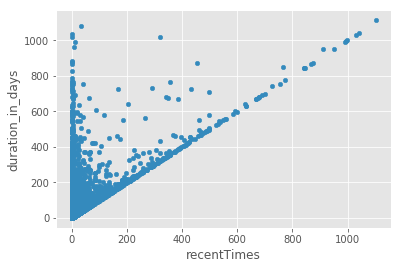

In [368]:
df2[df2.duration_in_days.notna()].groupby('work_item').first().plot(kind = 'scatter',x ='recentTimes',y='duration_in_days') #.groupby('recentTimes')['duration_in_days'].mean().plot()

#recenttime as binned variable
## for open items with single entry - 2018/3/30 minus date ticket was opened
#Include timet to finish from each state

In [107]:
last_phase[last_phase.duration_in_days.isna()].last_phase.unique()

# array(['Deploy', 'Build', 'Package', 'Analyze', 'Design'], dtype=object) #not na

array(['Build', 'Analyze', 'Test', 'Design', 'Clarify', 'Deploy',
       'Package', 'Accept'], dtype=object)

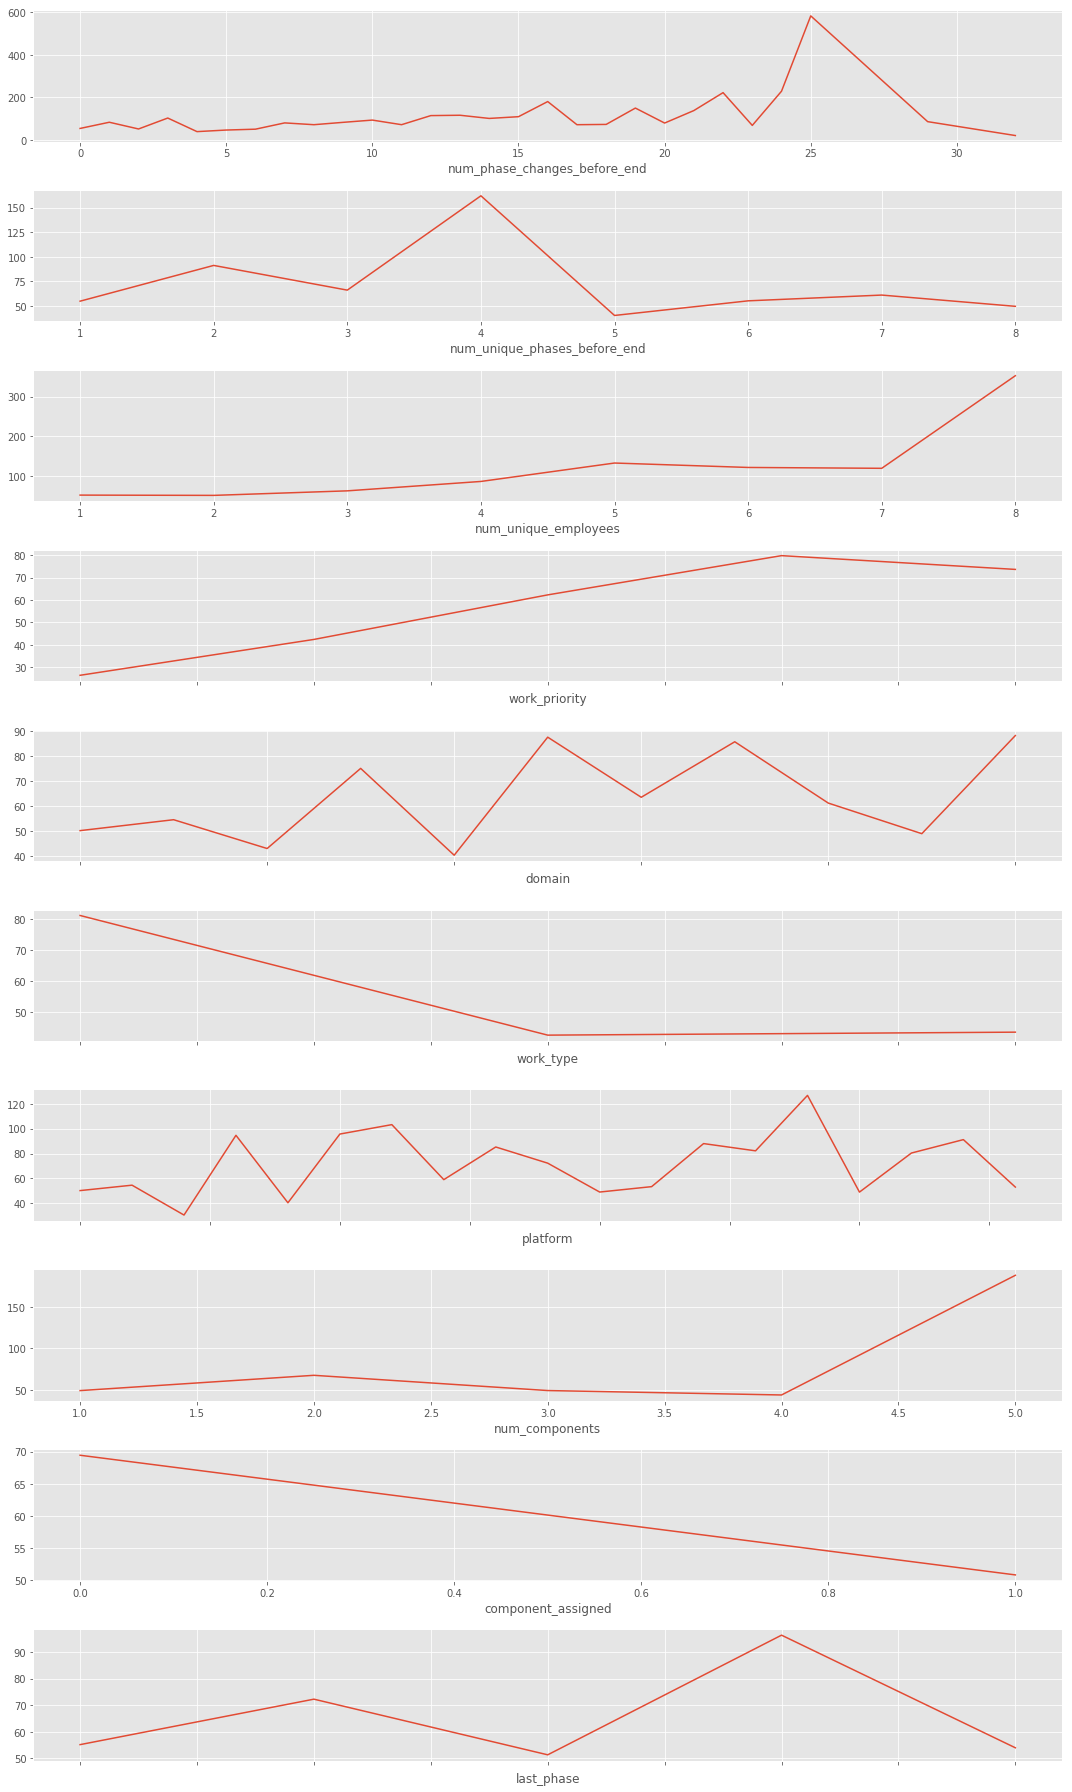

In [177]:
fig, axes = plt.subplots(10,1,figsize=(15,25))

df2.groupby('work_item').first().groupby('num_phase_changes_before_end')['duration_in_days'].mean().plot(ax = axes[0])

df2.groupby('work_item').first().groupby('num_unique_phases_before_end')['duration_in_days'].mean().plot(ax = axes[1])

df2.groupby('work_item').first().groupby('num_unique_employees')['duration_in_days'].mean().plot(ax = axes[2])

df2.groupby('work_item').first().groupby('work_priority')['duration_in_days'].mean().plot(ax = axes[3])

df2.groupby('work_item').first().groupby('domain')['duration_in_days'].mean().plot(ax = axes[4])

df2.groupby('work_item').first().groupby('work_type')['duration_in_days'].mean().plot(ax = axes[5])

df2.groupby('work_item').first().groupby('platform')['duration_in_days'].mean().plot(ax = axes[6])

df2.groupby('work_item').first().groupby('num_components')['duration_in_days'].mean().plot(ax = axes[7])
df2.groupby('work_item').first().groupby('component_assigned')['duration_in_days'].mean().plot(ax = axes[8])

df2.groupby('work_item').first().groupby('last_phase')['duration_in_days'].mean().plot(ax = axes[9])


# for i in range(len(axes)):
#     axes[i].set_ylim(bottom = 0)
fig.tight_layout()

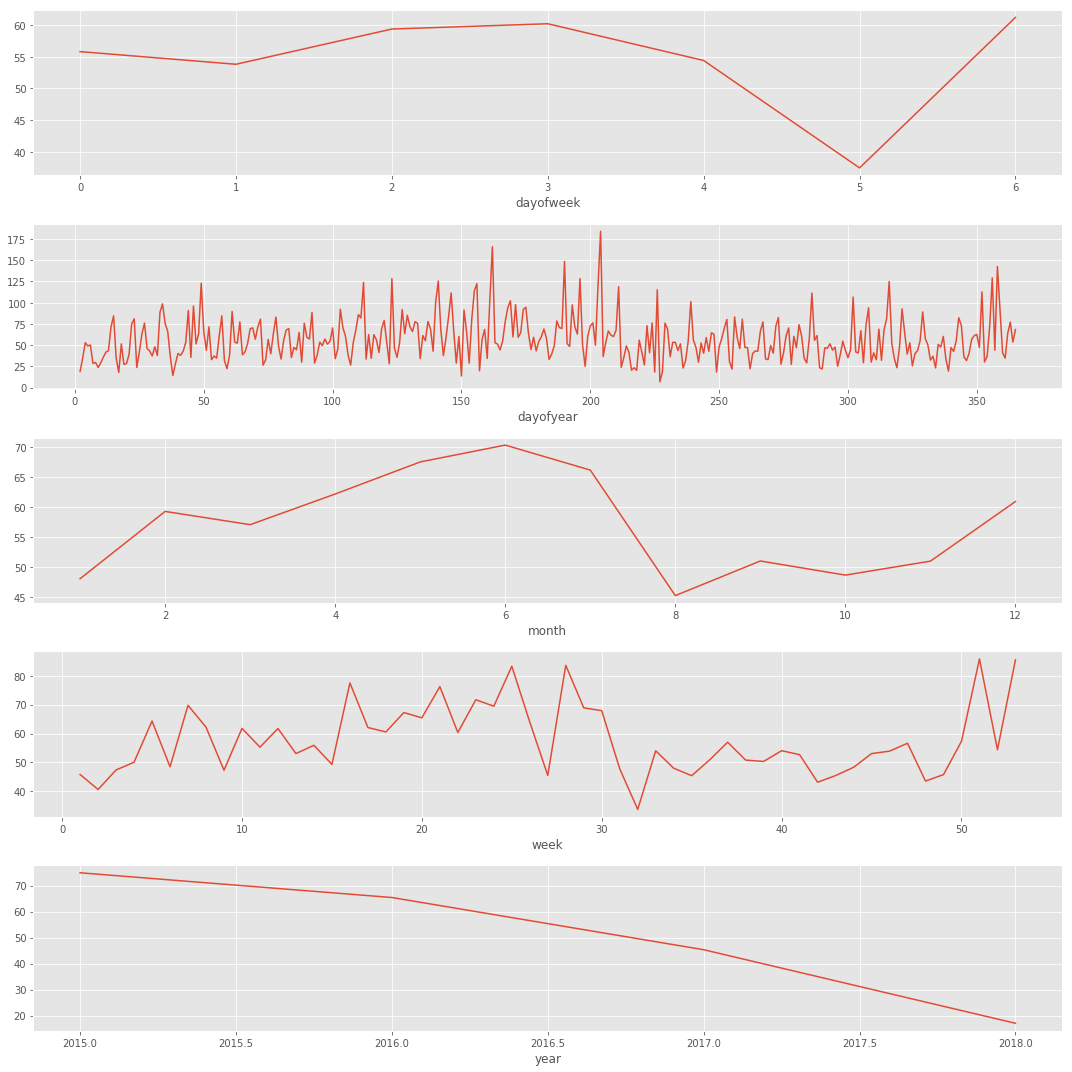

In [358]:
fig, axes = plt.subplots(5,1,figsize=(15,15))

df2.groupby('work_item').first().groupby('dayofweek')['duration_in_days'].mean().plot(ax = axes[0])

df2.groupby('work_item').first().groupby('dayofyear')['duration_in_days'].mean().plot(ax = axes[1])

df2.groupby('work_item').first().groupby('month')['duration_in_days'].mean().plot(ax = axes[2])

df2.groupby('work_item').first().groupby('week')['duration_in_days'].mean().plot(ax = axes[3])

df2.groupby('work_item').first().groupby('year')['duration_in_days'].mean().plot(ax = axes[4])


# for i in range(len(axes)):
#     axes[i].set_ylim(bottom = 0)
fig.tight_layout()

In [247]:
df2[df2.duration_in_days.notna()].groupby('work_item').first()\
    .groupby(['work_type', 'work_priority', 'domain',
       'platform', 'components'], as_index = False)['duration_in_days']\
    .agg({'mean','count'}) #looks like domain has interaction

# WI_011404-------WT_00001	WP_00002	BD_00009	PL_00019	not_assigned
# WI_011434 -------WT_00001	WP_00005	BD_00006	PL_00006	not_assigned	
# WI_011467------WT_00001	WP_00004	BD_00007	PL_00012	CO_00064

mean  \
work_type work_priority domain   platform components                                                 
WT_00001  WP_00001      BD_00001 PL_00001 CO_00011                                       55.976667   
                                          CO_00014                                        0.970000   
                                          CO_00055                                        0.120000   
                                          CO_00062                                        7.090000   
                                          CO_00096                                        0.120000   
                                          CO_00099                                       52.825000   
                                          CO_00173                                       13.043333   
                                          CO_00174                                       60.052000   
                                          not_assigned                                   13.340476   
                        BD_00002 PL_00002 CO_00010                                       10.669091   
                                          CO_00035                                       12.862857   
                                          CO_00069                                        2.910000   
                                          CO_00153                                       42.970000   
                                          not_assigned                                    0.790000   
                        BD_00003 PL_00003 CO_00083                                      106.550000   
                                          CO_00113                                        5.990000   
                                 PL_00008 CO_00118                                       20.850000   
                        BD_00004 PL_00004 not_assigned                                   90.784545   
                                 PL_00011 not_assigned                                   77.810000   
                        BD_00005 PL_00005 CO_00026                                       14.354286   
                                          CO_00027                                        1.040000   
                                          CO_00075                                        9.760000   
                                          CO_00139                                       28.862857   
                                          CO_00140                                       11.810000   
                                          CO_00140/CO_00027                             156.460000   
                                          CO_00141                                       58.825000   
                                          CO_00160                                        6.553333   
                                          CO_00164                                       11.163333   
                                          CO_00177                                      356.300000   
                                          not_assigned                                    5.550000   
                        BD_00006 PL_00006 CO_00003                                       17.430000   
                                          CO_00029                                        8.960000   
                                          not_assigned                                   30.576364   
                                 PL_00010 not_assigned                                   51.827778   
                        BD_00007 PL_00007 not_assigned                                   32.034000   
                                 PL_00012 CO_00031                                        7.900000   
                                          CO_00064                                       28.840000   
                                          not_assigned                                   37.615000   
              

In [182]:
df2[df2.duration_in_days.isna()].groupby('work_item').first()\
    .groupby('last_phase').count()

,timestamp,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource,duration_in_days,work_type_encoding,domain_encoding,platform_encoding,work_priority_encoding,num_components,components_encoding,component_assigned,num_phase_changes_before_end,num_unique_phases_before_end,num_unique_employees,dayofweek,month,recentTimes,recentTimes2,Accept,Analyze,Build,Clarify,Deploy,Design,Package,Test
last_phase,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Accept,87,87,87,87,87,87,87,87,87,87,0,87,87,87,87,73,81,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87
Analyze,583,583,583,583,583,583,583,583,67,583,0,583,583,583,583,359,556,583,583,583,583,583,583,67,583,583,583,583,583,583,583,583,583
Build,84,84,84,84,84,84,84,84,84,84,0,84,84,84,84,54,78,84,84,84,84,84,84,84,84,84,84,84,84,84,84,84,84
Clarify,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Deploy,80,80,80,80,80,80,80,80,80,80,0,80,80,80,80,39,72,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80,80
Design,141,141,141,141,141,141,141,141,141,141,0,141,141,141,141,83,129,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141
Package,14,14,14,14,14,14,14,14,14,14,0,14,14,14,14,6,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
Test,52,52,52,52,52,52,52,52,52,52,0,52,52,52,52,31,51,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52


In [373]:
df2.query("work_item == 'WI_000264'")
df2.query("work_item == 'WI_006611'") 
# df2.query("work_item == 'WI_000165'")
##find the last stage of closed ticket before closing and add as a column (or multiple column for each stage)
## Add avg time spent in each stage of the ticket.
## check for tickets with very short time. find out why they are being closed so soon.

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource,duration_in_days,work_type_encoding,domain_encoding,platform_encoding,work_priority_encoding,num_components,components_encoding,component_assigned,num_phase_changes_before_end,num_unique_phases_before_end,num_unique_employees,work_priority_ordered,dayofweek,dayofyear,month,week,year
39489,2017-02-24 16:17:10,WI_006611,WT_00001,WP_00002,BD_00006,PL_00006,not_assigned,Start,Analyze,NaN,ER_00013,NaN,82.91,84.8,88.21,49.02,NaN,76.1,0,16,16,5,4,4,55,2,8,2017
52900,2017-09-07 10:37:49,WI_006611,WT_00001,WP_00002,BD_00006,PL_00006,not_assigned,Analyze,Design,ER_00013,ER_00180,NaN,82.91,84.8,88.21,49.02,NaN,76.1,0,16,16,5,4,3,250,9,36,2017
52901,2017-09-07 10:38:00,WI_006611,WT_00001,WP_00002,BD_00006,PL_00006,not_assigned,Design,Build,ER_00180,ER_00180,NaN,82.91,84.8,88.21,49.02,NaN,76.1,0,16,16,5,4,3,250,9,36,2017
55886,2017-10-10 16:11:47,WI_006611,WT_00001,WP_00002,BD_00006,PL_00006,not_assigned,Build,Design,ER_00180,ER_00204,NaN,82.91,84.8,88.21,49.02,NaN,76.1,0,16,16,5,4,1,283,10,41,2017
68810,2018-02-22 11:07:06,WI_006611,WT_00001,WP_00002,BD_00006,PL_00006,not_assigned,Design,Build,ER_00204,ER_00099,NaN,82.91,84.8,88.21,49.02,NaN,76.1,0,16,16,5,4,3,53,2,8,2018
69477,2018-03-02 11:28:10,WI_006611,WT_00001,WP_00002,BD_00006,PL_00006,not_assigned,Build,Test,ER_00099,ER_00180,NaN,82.91,84.8,88.21,49.02,NaN,76.1,0,16,16,5,4,4,61,3,9,2018
69478,2018-03-02 11:28:15,WI_006611,WT_00001,WP_00002,BD_00006,PL_00006,not_assigned,Test,Package,ER_00180,ER_00180,NaN,82.91,84.8,88.21,49.02,NaN,76.1,0,16,16,5,4,4,61,3,9,2018
70415,2018-03-14 15:47:29,WI_006611,WT_00001,WP_00002,BD_00006,PL_00006,not_assigned,Package,Accept,ER_00180,ER_00099,NaN,82.91,84.8,88.21,49.02,NaN,76.1,0,16,16,5,4,2,73,3,11,2018
70768,2018-03-19 13:02:57,WI_006611,WT_00001,WP_00002,BD_00006,PL_00006,not_assigned,Accept,Test,ER_00099,ER_00108,NaN,82.91,84.8,88.21,49.02,NaN,76.1,0,16,16,5,4,0,78,3,12,2018
70773,2018-03-19 13:22:43,WI_006611,WT_00001,WP_00002,BD_00006,PL_00006,not_assigned,Test,Build,ER_00108,ER_00099,NaN,82.91,84.8,88.21,49.02,NaN,76.1,0,16,16,5,4,0,78,3,12,2018


In [18]:
def sort_x(x):
    if isinstance(x, list):
        sorted(x)
        return x
    
df_component = df.components.str.split('/').apply(sort_x).apply(pd.Series)\
.rename(columns = {0:'Component_1', 1:'Component_2', 2:'Component_3', 3:'Component_4', 4:'Component_5'})

# components = set(df_component.Component_0.dropna().unique()).union(set(df_component.Component_1.dropna().unique()))\
#                 .union(set(df_component.Component_2.dropna().unique())).union(set(df_component.Component_3.dropna().unique()))
# # components.remove('nan')
# component_mapping = {x:i+1 for i,x in enumerate(components)}
# for col in df_component.columns:
#     df_component[col] = df_component[col].map(component_mapping)
df_component.head()

,Component_1,Component_2,Component_3,Component_4,Component_5
0,NaN,NaN,NaN,NaN,NaN
1,CO_00037,CO_00071,NaN,NaN,NaN
2,CO_00037,CO_00071,NaN,NaN,NaN
3,CO_00037,CO_00071,NaN,NaN,NaN
4,CO_00113,NaN,NaN,NaN,NaN


In [370]:
onehotencoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
wt = onehotencoder.fit_transform(df[['work_type']])
df_work_type = pd.DataFrame(wt, columns = ['work_type'+str(int(i+1)) for i in range(wt.shape[1])])
df_work_type.head(4)

wp = onehotencoder.fit_transform(df[['domain']])
df_domain = pd.DataFrame(wp, columns = ['domain'+str(int(i+1)) for i in range(wp.shape[1])])
df_domain.head(4)

platform = onehotencoder.fit_transform(df[['platform']])
df_platform = pd.DataFrame(platform, columns = ['platform'+str(int(i+1)) for i in range(platform.shape[1])])
df_platform.head(4)


df_final = pd.concat([df_final,df_domain,df_work_type,df_platform], axis = 1)
df_final.head(3)

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource,Component_0,Component_1,Component_2,Component_3,Component_4,unique_components,work_priority_ordered,dayofweek,dayofyear,month,week,year,domain1,domain2,domain3,domain4,domain5,domain6,domain7,domain8,domain9,domain10,domain11,work_type1,work_type2,work_type3,platform1,platform2,platform3,platform4,platform5,platform6,platform7,platform8,platform9,platform10,platform11,platform12,platform13,platform14,platform15,platform16,platform17,platform18,platform19
0,2015-01-02 14:39:14,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,NaN,Start,Analyze,NaN,ER_00043,NaN,NaN,NaN,NaN,NaN,NaN,3,4,2,1,1,2015,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-01-02 15:04:20,WI_000002,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225,113.0,63.0,NaN,NaN,NaN,2.0,2,4,2,1,1,2015,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-02 15:28:22,WI_000003,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225,113.0,63.0,NaN,NaN,NaN,2.0,2,4,2,1,1,2015,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [575]:
print(df2.columns)
relevant_columns_train = ['timestamp','work_item','duration_in_days',  'work_type_encoding',
       'num_components', 'components_encoding', 'component_assigned',
       'num_phase_changes_before_end', 'num_unique_employees',
       'work_priority_ordered', 'dayofweek', 'month',
        'recentTimes2', 'recentTime_200', 'domain_BD_00001',
       'domain_BD_00002', 'domain_BD_00003', 'domain_BD_00004',
       'domain_BD_00005', 'domain_BD_00006', 'domain_BD_00007',
       'domain_BD_00008', 'domain_BD_00009', 'domain_BD_00010',
       'domain_BD_00011', 'platform_PL_00001', 'platform_PL_00002',
       'platform_PL_00003', 'platform_PL_00004', 'platform_PL_00005',
       'platform_PL_00006', 'platform_PL_00007', 'platform_PL_00008',
       'platform_PL_00009', 'platform_PL_00010', 'platform_PL_00011',
       'platform_PL_00012', 'platform_PL_00013', 'platform_PL_00014',
       'platform_PL_00015', 'platform_PL_00016', 'platform_PL_00017',
       'platform_PL_00018', 'platform_PL_00019', 'avg_time_res' ]

Index(['timestamp', 'work_item', 'work_type', 'work_priority', 'domain',
       'platform', 'components', 'from_phase', 'to_phase', 'from_resource',
       'to_resource', 'duration_in_days', 'work_type_encoding',
       'num_components', 'components_encoding', 'component_assigned',
       'num_phase_changes_before_end', 'num_unique_employees',
       'work_priority_ordered', 'dayofweek', 'dayofyear', 'month', 'week',
       'recentTimes', 'recentTimes2', 'recentTime_200', 'domain_BD_00001',
       'domain_BD_00002', 'domain_BD_00003', 'domain_BD_00004',
       'domain_BD_00005', 'domain_BD_00006', 'domain_BD_00007',
       'domain_BD_00008', 'domain_BD_00009', 'domain_BD_00010',
       'domain_BD_00011', 'platform_PL_00001', 'platform_PL_00002',
       'platform_PL_00003', 'platform_PL_00004', 'platform_PL_00005',
       'platform_PL_00006', 'platform_PL_00007', 'platform_PL_00008',
       'platform_PL_00009', 'platform_PL_00010', 'platform_PL_00011',
       'platform_PL_00012', 'platf

In [576]:
df_train = df2[relevant_columns_train]
df_train = df_train.groupby('work_item', as_index = False).first()
df_train.head()

,work_item,timestamp,duration_in_days,work_type_encoding,num_components,components_encoding,component_assigned,num_phase_changes_before_end,num_unique_employees,work_priority_ordered,dayofweek,month,recentTimes2,recentTime_200,domain_BD_00001,domain_BD_00002,domain_BD_00003,domain_BD_00004,domain_BD_00005,domain_BD_00006,domain_BD_00007,domain_BD_00008,domain_BD_00009,domain_BD_00010,domain_BD_00011,platform_PL_00001,platform_PL_00002,platform_PL_00003,platform_PL_00004,platform_PL_00005,platform_PL_00006,platform_PL_00007,platform_PL_00008,platform_PL_00009,platform_PL_00010,platform_PL_00011,platform_PL_00012,platform_PL_00013,platform_PL_00014,platform_PL_00015,platform_PL_00016,platform_PL_00017,platform_PL_00018,platform_PL_00019,avg_time_res
0,WI_000001,2015-01-02 14:39:14,24.87,83.72,NaN,74.33,0,10,3,3,4,1,7.02,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,247.56
1,WI_000002,2015-01-02 15:04:20,11.78,46.56,2.0,60.18,1,2,1,2,4,1,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,208.20
2,WI_000003,2015-01-02 15:28:22,54.85,46.56,2.0,60.18,1,6,1,2,4,1,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,208.20
3,WI_000004,2015-01-02 15:33:54,25.73,46.56,2.0,60.18,1,6,3,2,4,1,11.89,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,208.20
4,WI_000005,2015-01-02 16:32:11,32.85,46.56,1.0,46.13,1,6,3,3,4,1,6.10,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,126.50


In [135]:
df2[mask_closed].groupby('work_item', as_index = False).first().query("from_phase == 'Start'").shape

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(11029, 47)

In [196]:
df_train.duration_in_days.min(), df_train.duration_in_days.quantile(0.99)

(0.0, 543.0194999999962)

In [424]:
time_min = df_train.timestamp.min()
time_max = df_train.timestamp.max()
time_delta = df_train.timestamp.max()- df_train.timestamp.min()
print(_)

(Timestamp('2015-01-02 14:39:14'), Timestamp('2018-03-30 16:47:46'), Timedelta('1183 days 02:08:32'))


In [428]:
time_intervals = [time_min + 1*(time_delta/4.5), time_min + 2*(time_delta/4.5), 
                  time_min + 3*(time_delta/4.5), time_min + 4*(time_delta/4.5)]
time_intervals

[Timestamp('2015-09-22 12:27:47.777777776'),
 Timestamp('2016-06-11 10:16:21.555555552'),
 Timestamp('2017-03-01 08:04:55.333333328'),
 Timestamp('2017-11-19 05:53:29.111111104')]

In [577]:
import datetime as dt
sep_date_str = '01.01.2018'
open_times = df_train[pd.isnull(df_train.duration_in_days)].reset_index(drop = True)
closed_times = df_train[~pd.isnull(df_train.duration_in_days)].reset_index(drop = True)

closed_times = closed_times[closed_times.duration_in_days >= 1].reset_index(drop = True)
closed_times = closed_times[closed_times.duration_in_days <= closed_times.duration_in_days.quantile(0.99)].reset_index(drop = True)

# sep_date = dt.datetime.strptime(sep_date_str, '%d.%m.%Y')
# train_times = closed_times[closed_times.end <= sep_date]
# test_times = closed_times[(closed_times.end > sep_date) & (closed_times.start <= sep_date)]

In [558]:
closed_times.head()

,work_item,timestamp,duration_in_days,work_type_encoding,num_components,component_assigned,component_1_encoding,component_2_encoding,component_3_encoding,component_4_encoding,component_5_encoding,num_phase_changes_before_end,num_unique_employees,work_priority_ordered,dayofweek,dayofyear,month,week,recentTimes2,Analyze,Build,Deploy,Design,Package,domain_BD_00001,domain_BD_00002,domain_BD_00003,domain_BD_00004,domain_BD_00005,domain_BD_00006,domain_BD_00007,domain_BD_00008,domain_BD_00009,domain_BD_00010,domain_BD_00011,platform_PL_00001,platform_PL_00002,platform_PL_00003,platform_PL_00004,platform_PL_00005,platform_PL_00006,platform_PL_00007,platform_PL_00008,platform_PL_00009,platform_PL_00010,platform_PL_00011,platform_PL_00012,platform_PL_00013,platform_PL_00014,platform_PL_00015,platform_PL_00016,platform_PL_00017,platform_PL_00018,platform_PL_00019,avg_time_res,phase_Design,phase_Build,phase_Test,phase_Package,phase_Accept,phase_Deploy,phase_End
0,WI_000001,2015-01-02 14:39:14,24.87,83.72,NaN,0,NaN,NaN,NaN,NaN,NaN,10,3,3,4,2,1,1,7.02,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,247.560655,1,1,1,1,1,1,0
1,WI_000002,2015-01-02 15:04:20,11.78,46.56,2.0,1,59.52,59.75,NaN,NaN,NaN,2,1,2,4,2,1,1,0.00,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,208.202560,1,1,1,0,0,0,0
2,WI_000003,2015-01-02 15:28:22,54.85,46.56,2.0,1,59.52,59.75,NaN,NaN,NaN,6,1,2,4,2,1,1,0.00,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,208.202560,1,1,1,1,0,0,0
3,WI_000004,2015-01-02 15:33:54,25.73,46.56,2.0,1,59.52,59.75,NaN,NaN,NaN,6,3,2,4,2,1,1,11.89,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,208.202560,1,1,1,1,1,1,0
4,WI_000005,2015-01-02 16:32:11,32.85,46.56,1.0,1,39.12,NaN,NaN,NaN,NaN,6,3,3,4,2,1,1,6.10,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,126.503539,1,1,1,0,1,1,0


In [552]:
closed_times.shape, open_times.shape

((9027, 63), (1042, 63))

In [302]:
closed_times.duration_in_days.quantile(0.99)

419.0322

In [578]:
train_cols = relevant_columns_train.copy()
train_cols.remove('work_item')
train_cols.remove('timestamp')
train_cols.remove('duration_in_days')
print(train_cols)
target = 'duration_in_days'
from sklearn.model_selection import train_test_split, StratifiedKFold

train_x, test_x,train_y,  test_y = train_test_split(closed_times[train_cols],closed_times.duration_in_days,
                                                    test_size = 0.2)

['work_type_encoding', 'num_components', 'components_encoding', 'component_assigned', 'num_phase_changes_before_end', 'num_unique_employees', 'work_priority_ordered', 'dayofweek', 'month', 'recentTimes2', 'recentTime_200', 'domain_BD_00001', 'domain_BD_00002', 'domain_BD_00003', 'domain_BD_00004', 'domain_BD_00005', 'domain_BD_00006', 'domain_BD_00007', 'domain_BD_00008', 'domain_BD_00009', 'domain_BD_00010', 'domain_BD_00011', 'platform_PL_00001', 'platform_PL_00002', 'platform_PL_00003', 'platform_PL_00004', 'platform_PL_00005', 'platform_PL_00006', 'platform_PL_00007', 'platform_PL_00008', 'platform_PL_00009', 'platform_PL_00010', 'platform_PL_00011', 'platform_PL_00012', 'platform_PL_00013', 'platform_PL_00014', 'platform_PL_00015', 'platform_PL_00016', 'platform_PL_00017', 'platform_PL_00018', 'platform_PL_00019', 'avg_time_res']


In [579]:
# Defining parameters

train_data = lgb.Dataset(train_x, label = train_y)
val_data = lgb.Dataset(test_x, label = test_y)

# train_data = lgb.Dataset(closed_times[train_cols], label = closed_times.duration_in_days)

params = {
    'metric': 'rmse',
    'objective': 'regression',
    'verbosity': 1,
    'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.6086242652505913,
   'learning_rate': 0.015311447809767412,
   'min_child_samples': 30,
   'num_leaves': 86,
   'reg_alpha': 0.5622329145053466,
   'reg_lambda': 0.747531261801519,
   'subsample_for_bin': 120000,
   'subsample': 0.6199014739949668
        
}



num_round = 20000

model = lgb.train(params, train_data, num_boost_round = num_round, verbose_eval=2000, 
                  valid_sets = [train_data, val_data],  early_stopping_rounds = 1000)


# model = lgb.train(params, train_data, num_boost_round = 636, verbose_eval=100,
#                   valid_sets = [train_data],  early_stopping_rounds = 100)

Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[760]	training's rmse: 39.1333	valid_1's rmse: 57.0249


In [580]:
open_predictions = pd.DataFrame(open_times.work_item)
open_predictions['predictions'] = model.predict(open_times[train_cols], num_iteration=model.best_iteration)
open_predictions.head(5)

,work_item,predictions
0,WI_000165,110.004135
1,WI_000196,440.392411
2,WI_000264,447.987900
3,WI_000273,240.380477
4,WI_000278,441.850044


In [581]:
neg_wi = list(open_predictions[open_predictions.predictions <0].work_item)
print(sum(open_predictions.predictions <0))
med_duration = df2.duration_in_days.quantile(q = 0.33)
med_duration

11


10.04

In [582]:
open_predictions.shape

(1042, 2)

In [583]:
df_open = df2[mask_open].reset_index(drop = True).groupby('work_item', as_index = False).first()

In [592]:
open_predictions = pd.DataFrame(open_times.work_item)
open_predictions['predictions_base'] = model.predict(open_times[train_cols], num_iteration=model.best_iteration)
open_predictions.head(5)

open_predictions.loc[open_predictions.predictions_base < 0,'predictions_base'] = -1*open_predictions.predictions_base

open_predictions = open_predictions.merge(df_open, on = 'work_item', how = 'left')
open_predictions['time_since_03302018'] = (pd.Timestamp('03/30/2018') - open_predictions.timestamp).dt.days
open_predictions['predictions'] = np.where(open_predictions.predictions_base < open_predictions.time_since_03302018, 
                                          open_predictions.predictions_base + open_predictions.time_since_03302018,
                                           open_predictions.predictions_base)

# open_predictions['predictions'] = np.where((open_predictions.work_priority.isin(['WP_00003', 'WP_00004','WP_00005'])), 
#                                           med_duration,
#                                            open_predictions.predictions)
                                           
open_predictions['predictions'] = np.where((open_predictions.predictions <5) & 
                                           (open_predictions.work_priority.isin(['WP_00003', 'WP_00004','WP_00005'])), 
                                          med_duration,
                                           open_predictions.predictions)                                         


##removing the (open_predictions.predictions_base/2)

# open_predictions.loc[open_predictions.predictions <2,'predictions'] = open_predictions.predictions + 10
open_predictions.head()

,work_item,predictions_base,timestamp,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource,duration_in_days,work_type_encoding,num_components,components_encoding,component_assigned,num_phase_changes_before_end,num_unique_employees,work_priority_ordered,dayofweek,dayofyear,month,week,recentTimes,recentTimes2,recentTime_200,domain_BD_00001,domain_BD_00002,domain_BD_00003,domain_BD_00004,domain_BD_00005,domain_BD_00006,domain_BD_00007,domain_BD_00008,domain_BD_00009,domain_BD_00010,domain_BD_00011,platform_PL_00001,platform_PL_00002,platform_PL_00003,platform_PL_00004,platform_PL_00005,platform_PL_00006,platform_PL_00007,platform_PL_00008,platform_PL_00009,platform_PL_00010,platform_PL_00011,platform_PL_00012,platform_PL_00013,platform_PL_00014,platform_PL_00015,platform_PL_00016,platform_PL_00017,platform_PL_00018,platform_PL_00019,timestamp_1lag,time_per_step_hrs,avg_time_res,time_since_03302018,predictions
0,WI_000165,110.004135,2015-01-21 13:04:29,WT_00002,WP_00004,BD_00008,PL_00009,not_assigned,Start,Analyze,ER_00063,ER_00063,NaN,46.56,NaN,74.33,0,2,2,2,2,21,1,4,0.00,0.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2015-01-21 13:04:29,13106.940556,2299.38,1163,1273.004135
1,WI_000196,440.392411,2015-01-23 15:11:17,WT_00001,WP_00002,BD_00007,PL_00012,CO_00116/CO_00031,Start,Analyze,NaN,ER_00080,NaN,83.72,2.0,NaN,1,0,1,4,4,23,1,4,NaN,1161.00,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,NaT,NaN,NaN,1161,1601.392411
2,WI_000264,447.987900,2015-01-30 17:00:47,WT_00003,WP_00003,BD_00008,PL_00013,not_assigned,Start,Analyze,NaN,ER_00221,NaN,46.75,NaN,74.33,0,0,1,3,4,30,1,5,NaN,1154.00,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NaT,NaN,NaN,1154,1601.987900
3,WI_000273,240.380477,2015-02-02 19:58:53,WT_00003,WP_00002,BD_00007,PL_00007,not_assigned,Start,Analyze,ER_00048,ER_00048,NaN,46.75,NaN,74.33,0,8,3,4,0,33,2,6,149.89,149.89,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2015-02-02 19:58:53,14.659444,539.66,1151,1391.380477
4,WI_000278,441.850044,2015-02-03 10:29:57,WT_00001,WP_00003,BD_00007,PL_00012,CO_00101,Start,Analyze,NaN,ER_00080,NaN,83.72,1.0,NaN,1,0,1,3,1,34,2,6,NaN,1150.00,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,NaT,NaN,NaN,1150,1591.850044


In [593]:
open_predictions[open_predictions['predictions'] <5]

,work_item,predictions_base,timestamp,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource,duration_in_days,work_type_encoding,num_components,components_encoding,component_assigned,num_phase_changes_before_end,num_unique_employees,work_priority_ordered,dayofweek,dayofyear,month,week,recentTimes,recentTimes2,recentTime_200,domain_BD_00001,domain_BD_00002,domain_BD_00003,domain_BD_00004,domain_BD_00005,domain_BD_00006,domain_BD_00007,domain_BD_00008,domain_BD_00009,domain_BD_00010,domain_BD_00011,platform_PL_00001,platform_PL_00002,platform_PL_00003,platform_PL_00004,platform_PL_00005,platform_PL_00006,platform_PL_00007,platform_PL_00008,platform_PL_00009,platform_PL_00010,platform_PL_00011,platform_PL_00012,platform_PL_00013,platform_PL_00014,platform_PL_00015,platform_PL_00016,platform_PL_00017,platform_PL_00018,platform_PL_00019,timestamp_1lag,time_per_step_hrs,avg_time_res,time_since_03302018,predictions


In [359]:
df2[df2.work_item.isin(['WI_011480'])]

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource,duration_in_days,work_type_encoding,domain_encoding,platform_encoding,work_priority_encoding,num_components,component_assigned,Component_1,Component_2,Component_3,Component_4,Component_5,component_1_encoding,component_2_encoding,component_3_encoding,component_4_encoding,component_5_encoding,num_phase_changes_before_end,num_unique_employees,work_priority_ordered,dayofweek,month,recentTimes,recentTimes2,recentTime_200,last_phase,Analyze,Build,Deploy,Design,Package,WP_00001,WP_00002,WP_00003,WP_00004,WP_00005,timestamp_1lag,time_per_step_hrs,avg_time_res,new_employee
71419,2018-03-26 11:10:51,WI_011480,WT_00002,WP_00003,BD_00005,PL_00005,CO_00026,Start,Analyze,NaN,ER_00156,NaN,46.56,46.19,46.19,67.11,1.0,1,CO_00026,NaN,NaN,NaN,NaN,42.23,NaN,NaN,NaN,NaN,0,1,3,0,3,NaN,3.0,0,Analyze,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,0


In [594]:
open_predictions[['work_item', 'predictions']].to_csv('submission_9_test_0503.csv', index = False)

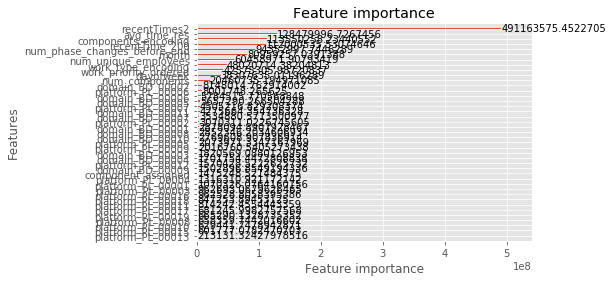

In [595]:
lgb.plot_importance(model, importance_type='gain')

In [206]:
num_round = 20000

model = lgb.train(params, train_data, num_boost_round = num_round, verbose_eval=2000, 
                  valid_sets = [train_data, val_data],  early_stopping_rounds = 2000,
                 categorical_feature=[0,1,2,3,4])

C:\Anaconda3\lib\site-packages\lightgbm\basic.py:1224: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Anaconda3\lib\site-packages\lightgbm\basic.py:1224: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Anaconda3\lib\site-packages\lightgbm\basic.py:775: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[2000]	training's rmse: 1.31666	valid_1's rmse: 2.02602
[4000]	training's rmse: 1.24439	valid_1's rmse: 2.0203
Early stopping, best iteration is:
[2974]	training's rmse: 1.27485	valid_1's rmse: 2.01596


In [224]:
params = {
    'metric': 'rmse',
    'objective': 'regression',
    'verbosity': 1,
    'learning_rate': 0.001
        
}

m = lgb.cv(params, cv_data, num_boost_round = 100, nfold = 2, early_stopping_rounds = 10,
           shuffle = False, stratified=False)

In [225]:
np.min(m['rmse-mean'])

80.86472084932156

In [330]:
##Using hyperopt
## Defining objective function

import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
N_FOLDS =5

cv_data = lgb.Dataset(closed_times[train_cols], label = closed_times.duration_in_days)

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
#     # Retrieve the subsample if present otherwise set to 1.0
#     subsample = params['boosting_type'].get('subsample', 1.0)
    
#     # Extract the boosting type
#     params['boosting_type'] = params['boosting_type']['boosting_type']
#     params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_data_in_leaf','subsample_freq','max_bin','max_depth']:
        params[parameter_name] = int(params[parameter_name])
        
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, cv_data, num_boost_round = 4000, nfold = n_folds, early_stopping_rounds = 500,
           shuffle = True, stratified=False, seed = 100, metrics = 'rmse')
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.min(cv_results['rmse-mean'])
    
    # Loss must be minimized
    loss = best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmin(cv_results['rmse-mean']) + 1)
    
    # Write to the csv file ('a' means append)
#     of_connection = open(out_file, 'a')
#     writer = csv.writer(of_connection)
#     writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [331]:
#Creating domain space

from hyperopt import hp
from hyperopt.pyll.stochastic import sample

# Define the search space
space = {
    'subsample': hp.uniform('subsample', 0.5, 1), # same as bagging_fraction
    'num_leaves': hp.quniform('num_leaves', 5, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    #'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5), #same as min_data_in_leaf
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.4, 1.0),
    'max_bin': hp.quniform('max_bin', 10,400, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 5,200, 1),
    'min_sum_hessian_in_leaf': hp.uniform('min_sum_hessian_in_leaf', 1e-5,10),
    #'bagging_fraction': hp.uniform('bagging_fraction', 0.2,1),
    'subsample_freq': hp.quniform('subsample_freq', 0,100, 1),
    'max_depth': hp.quniform('bagging_freq', -5,10, 1),
    'min_gain_to_split': hp.uniform('bagging_fraction', 0.0,5)
}

from hyperopt import tpe

# optimization algorithm
tpe_algorithm = tpe.suggest

from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

In [332]:
# File to save first results
out_file = 'gbm_bayes_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [333]:
from hyperopt import fmin
# Global variable
global  ITERATION

ITERATION = 0
MAX_EVALS = 400

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

100%|████████████████████████████████████████████████| 400/400 [1:33:09<00:00, 13.12s/it, best loss: 58.60115141605816]


In [335]:
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'loss': 58.60115141605816,
  'params': {'colsample_bytree': 0.5771449012216017,
   'learning_rate': 0.012211046066082077,
   'max_bin': 138,
   'max_depth': -3,
   'min_data_in_leaf': 5,
   'min_gain_to_split': 3.0203774239225716,
   'min_sum_hessian_in_leaf': 2.9907252704202776,
   'num_leaves': 80,
   'reg_alpha': 0.10059632969131486,
   'reg_lambda': 0.6758240091819094,
   'subsample': 0.5943964805701546,
   'subsample_for_bin': 260000,
   'subsample_freq': 4},
  'iteration': 291,
  'estimators': 636,
  'train_time': 13.46439372900204,
  'status': 'ok'},
 {'loss': 58.653035088285584,
  'params': {'colsample_bytree': 0.6361012117813717,
   'learning_rate': 0.020274412181855987,
   'max_bin': 223,
   'max_depth': -4,
   'min_data_in_leaf': 5,
   'min_gain_to_split': 3.3736863424878214,
   'min_sum_hessian_in_leaf': 3.4299133244597586,
   'num_leaves': 82,
   'reg_alpha': 0.24816069766393473,
   'reg_lambda': 0.8164516012294061,
   'subsample': 0.5794236781389087,
   'subsample_for_b

In [287]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:10]

{'loss': 100.6528088590428,
  'params': {'boosting_type': 'goss',
   'class_weight': 'balanced',
   'colsample_bytree': 0.7166163539795137,
   'learning_rate': 0.08861099178186711,
   'min_child_samples': 230,
   'num_leaves': 47,
   'reg_alpha': 0.09171650704169731,
   'reg_lambda': 0.37359381666650815,
   'subsample_for_bin': 200000,
   'subsample': 1.0},
  'iteration': 382,
  'estimators': 1,
  'train_time': 0.46237404900602996,
  'status': 'ok'},

#params used for best submission so far
{'loss': 98.75968807755729,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.8470509316344612,
   'learning_rate': 0.016879568426293543,
   'min_child_samples': 20,
   'num_leaves': 30,
   'reg_alpha': 0.40912060946409273,
   'reg_lambda': 0.9719911984484524,
   'subsample_for_bin': 80000,
   'subsample': 0.5859665295101489},
  'iteration': 288,
  'estimators': 1,
  'train_time': 11.911331509007141,
  'status': 'ok'},

[{'loss': 100.6528088590428,
  'params': {'boosting_type': 'goss',
   'class_weight': 'balanced',
   'colsample_bytree': 0.7166163539795137,
   'learning_rate': 0.08861099178186711,
   'min_child_samples': 230,
   'num_leaves': 47,
   'reg_alpha': 0.09171650704169731,
   'reg_lambda': 0.37359381666650815,
   'subsample_for_bin': 200000,
   'subsample': 1.0},
  'iteration': 382,
  'estimators': 1,
  'train_time': 0.46237404900602996,
  'status': 'ok'},
 {'loss': 100.67679235224347,
  'params': {'boosting_type': 'goss',
   'class_weight': 'balanced',
   'colsample_bytree': 0.6866245197274927,
   'learning_rate': 0.051109142152004315,
   'min_child_samples': 200,
   'num_leaves': 35,
   'reg_alpha': 0.004965276362652482,
   'reg_lambda': 0.22353259038347206,
   'subsample_for_bin': 200000,
   'subsample': 1.0},
  'iteration': 350,
  'estimators': 1,
  'train_time': 0.4379906200047117,
  'status': 'ok'},
 {'loss': 100.82265178333711,
  'params': {'boosting_type': 'goss',
   'class_weight':

In [234]:
open_predictions = pd.DataFrame(open_times.work_item)
open_predictions['predictions'] = model.predict(open_times[relevant_columns_train], num_iteration=model.best_iteration)
open_predictions.head(5)

,work_item,predictions
164,WI_000165,91.781465
195,WI_000196,40.568605
263,WI_000264,67.725771
272,WI_000273,220.557035
277,WI_000278,175.963067


In [219]:
open_predictions['predictions'] = np.where(open_predictions['predictions'] <0, 0, open_predictions['predictions'])

In [221]:
open_predictions[open_predictions['predictions'] <0]

,work_item,predictions


In [ ]:
open_predictions.to_csv("Submission_6.csv", index = False)

In [411]:
open_predictions.head(5)

,work_item,predictions
164,WI_000165,91.781465
195,WI_000196,40.568605
263,WI_000264,67.725771
272,WI_000273,220.557035
277,WI_000278,175.963067


In [413]:
df.query("work_item == 'WI_000196'")

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
761,2015-01-23 15:11:17,WI_000196,WT_00001,WP_00002,BD_00007,PL_00012,CO_00116/CO_00031,Start,Analyze,NaN,ER_00080


In [ ]:
## Number of stages ticket has been already
# time difference between current and start stage

In [43]:
resample_period = 'D'  # We’re going to resample the dataframe per day

# Calculate open tickets per day
open_per_day = times.resample(resample_period, on='timestamp_x').work_item.count().rename('open_tickets_per_day')

# Calculate closed tickets per day
is_closed = times.timestamp_y.notnull()  # tickets not closed yet have timestamp_y == NaT, let’s use this fact to create a quick filer
closed_per_day = times.loc[is_closed].resample(resample_period, on='timestamp_y').work_item.count().rename('closed_tickets_per_day')

# Let’s  concatenate the two dataframes and do some clean-up along the way
tickets_df = (pd.concat([open_per_day, closed_per_day], axis=1) # Join the two dataframes
                .fillna(0)                                      # Replace NaNs by 0 for those days when no tickets are opened or closed
                .astype(int)                                    # While we're at it, all counts are integers
                .reset_index()                                  # timestamp_x is used as index, move it back to a column
                .rename(columns={'timestamp_x': 'date'})        # and rename it to ‘date’
             )

tickets_df['open_tickets_total'] = tickets_df.open_tickets_per_day.cumsum()
tickets_df['closed_tickets_total'] = tickets_df.closed_tickets_per_day.cumsum()
tickets_df['wip_tickets_total'] = tickets_df.open_tickets_total - tickets_df.closed_tickets_total

In [45]:
tickets_df.head(10)

,date,open_tickets_per_day,closed_tickets_per_day,open_tickets_total,closed_tickets_total,wip_tickets_total
0,2015-01-02,6,0,6,0,6
1,2015-01-03,1,0,7,0,7
2,2015-01-04,2,0,9,0,9
3,2015-01-05,22,0,31,0,31
4,2015-01-06,17,7,48,7,41
5,2015-01-07,5,0,53,7,46
6,2015-01-08,4,3,57,10,47
7,2015-01-09,3,1,60,11,49
8,2015-01-10,2,0,62,11,51
9,2015-01-11,0,0,62,11,51


In [51]:
start_df = df.query("from_phase == 'Start'")
print(start_df.shape)
end_df = df.query("to_phase == 'End'")
print(end_df.shape)

times = start_df.merge(end_df, how )

(11564, 11)
(10522, 11)


In [5]:
df.from_phase.fillna('Start', inplace=True)  
df.to_phase.fillna('End', inplace=True)
df.components.fillna('', inplace=True)

In [6]:
df.head()

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
0,2015-01-02 14:39:14,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,,Start,Analyze,NaN,ER_00043
1,2015-01-02 15:04:20,WI_000002,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225
2,2015-01-02 15:28:22,WI_000003,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225
3,2015-01-02 15:33:54,WI_000004,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225
4,2015-01-02 16:32:11,WI_000005,WT_00002,WP_00003,BD_00003,PL_00003,CO_00113,Start,Analyze,NaN,ER_00206


In [7]:
relevant_columns = ['work_item', 'timestamp']
start_times = df[df.from_phase == 'Start'][relevant_columns]
end_times = df[df.to_phase == 'End'][relevant_columns]


In [9]:
end_times.head()

,work_item,timestamp
63,WI_000013,2015-01-06 09:18:30
65,WI_000033,2015-01-06 09:20:33
97,WI_000034,2015-01-06 13:24:41
111,WI_000036,2015-01-06 14:03:06
113,WI_000035,2015-01-06 14:51:17


In [10]:
times = pd.merge(start_times, end_times, on='work_item', how='left')
times.rename(columns={'timestamp_x': 'start', 'timestamp_y': 'end'}, inplace=True)
times['duration'] = times['end'] - times['start']
times['duration_in_days'] = times['duration'].apply(lambda x: round(x.total_seconds() / (24*3600), 2))

In [11]:
times.head()

,work_item,start,end,duration,duration_in_days
0,WI_000001,2015-01-02 14:39:14,2015-01-27 11:36:51,24 days 20:57:37,24.87
1,WI_000002,2015-01-02 15:04:20,2015-01-14 09:46:37,11 days 18:42:17,11.78
2,WI_000003,2015-01-02 15:28:22,2015-02-26 11:50:37,54 days 20:22:15,54.85
3,WI_000004,2015-01-02 15:33:54,2015-01-28 09:11:05,25 days 17:37:11,25.73
4,WI_000005,2015-01-02 16:32:11,2015-02-04 12:57:49,32 days 20:25:38,32.85


In [ ]:
open_times = times[pd.isnull(times.duration)]
closed_times = times[~pd.isnull(times.duration)]
sep_date = dt.datetime.strptime(sep_date_str, '%d.%m.%Y')
train_times = closed_times[closed_times.end <= sep_date]
test_times = closed_times[(closed_times.end > sep_date) & (closed_times.start <= sep_date)]

In [258]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.shape)

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
(4, 9)


In [263]:
print(X)

  (0, 8)	0.38408524091481483
  (0, 3)	0.38408524091481483
  (0, 6)	0.38408524091481483
  (0, 2)	0.5802858236844359
  (0, 1)	0.46979138557992045
  (1, 8)	0.281088674033753
  (1, 3)	0.281088674033753
  (1, 6)	0.281088674033753
  (1, 1)	0.6876235979836938
  (1, 5)	0.5386476208856763
  (2, 8)	0.267103787642168
  (2, 3)	0.267103787642168
  (2, 6)	0.267103787642168
  (2, 0)	0.511848512707169
  (2, 7)	0.511848512707169
  (2, 4)	0.511848512707169
  (3, 8)	0.38408524091481483
  (3, 3)	0.38408524091481483
  (3, 6)	0.38408524091481483
  (3, 2)	0.5802858236844359
  (3, 1)	0.46979138557992045
